<a href="https://colab.research.google.com/github/GJRao/BioInformatics/blob/main/SCV%20classifier/DEG__3_classes_with_StackingCVClassifier_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import matplotlib . pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn . decomposition import PCA
from sklearn . preprocessing import MaxAbsScaler,StandardScaler

In [ ]:
df=pd.read_csv('/content/gdrive/My Drive/Bioinfo/paper 3/eXP1/res_data_3_classes.csv',index_col=False)

In [ ]:
import imblearn
X=df.iloc[:,1:177]
y=df.iloc[:,-1]

In [ ]:
#scaler = StandardScaler()
scaler = MaxAbsScaler()
X_scale= scaler.fit_transform(X)

In [ ]:
from sklearn.preprocessing import LabelEncoder
# create object of Ordinalencoding
encoder= LabelEncoder()
y_en= encoder.fit_transform(y)
classes=encoder.classes_
classes

array(['DOWN', 'NS', 'UP'], dtype=object)

In [ ]:
pca = PCA()
projected = pca.fit_transform(X_scale)
print(projected.shape)

(1825, 176)


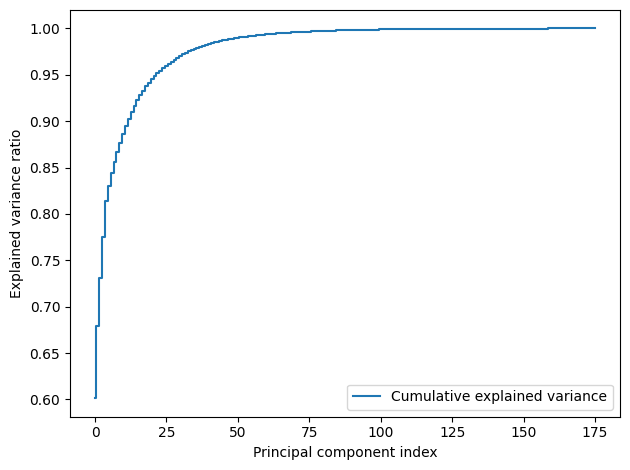

In [ ]:
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
#plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Second Principal Component')

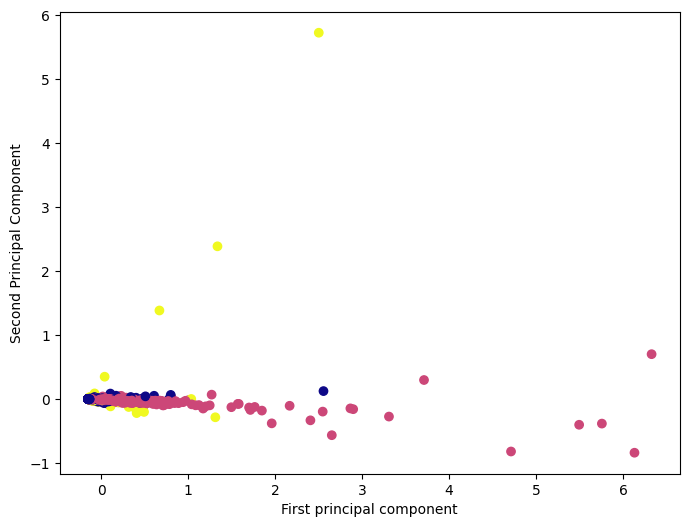

In [ ]:
pca = PCA(n_components=25)
X_trans = pca.fit_transform(X_scale)

plt.figure(figsize=(8,6))
plt.scatter(X_trans[:,0],X_trans[:,1],c=y_en,cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier

In [ ]:
from mlxtend.classifier import StackingCVClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection

In [ ]:
# transform the dataset
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X1, y1 = oversample.fit_resample(X_trans, y_en)

In [ ]:
#For XGBoost clf only
y1_en= encoder.fit_transform(y1)
y1_en=pd.DataFrame(y1_en)

In [ ]:
RANDOM_SEED = 42

clf1 = KNeighborsClassifier(metric='euclidean', n_neighbors=2, weights='uniform')
clf2 = RandomForestClassifier(random_state=RANDOM_SEED,max_features= 'log2', n_estimators=1000)
clf3 = MLPClassifier(activation = "relu", alpha = 0.1, hidden_layer_sizes = (10,10,10),
                            learning_rate = "constant", max_iter = 2000, random_state = 1000)
clf6 = XGBClassifier(learning_rate=0.2, max_depth=9, n_estimators=50,subsample=0.5)
clf4 = SVC(C= 30, gamma= 1, kernel='rbf',probability = True)
clf5 = GradientBoostingClassifier(learning_rate= 0.1, max_depth=9, n_estimators=100, subsample= 0.5)
lr = LogisticRegression(solver='lbfgs', max_iter=400)

In [ ]:
sclf = StackingCVClassifier(classifiers=[clf1,clf2,clf5],
                            shuffle = False,
                            use_probas = True,
                            cv = 5,
                            meta_classifier = lr)

In [ ]:
params = {'kneighborsclassifier__n_neighbors': [2],
          'randomforestclassifier__n_estimators': [50],
          'meta_classifier__C': [0.1, 10.0]
          }

In [ ]:
grid = GridSearchCV(estimator=sclf,
                    param_grid=params,
                    cv=5,
                    refit=True)
grid.fit(X1, y1)

cv_keys = ('mean_test_score', 'std_test_score', 'params')

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_[cv_keys[0]][r],
             grid.cv_results_[cv_keys[1]][r] / 2.0,
             grid.cv_results_[cv_keys[2]][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.936 +/- 0.01 {'kneighborsclassifier__n_neighbors': 2, 'randomforestclassifier__n_estimators': 50}
Best parameters: {'kneighborsclassifier__n_neighbors': 2, 'randomforestclassifier__n_estimators': 50}
Accuracy: 0.94


In [ ]:
# Learn to predict each class against the other

classifier = OneVsRestClassifier(sclf)

In [ ]:
from sklearn.preprocessing import label_binarize
# Binarize the output
y1 = label_binarize(y1, classes=[0, 1, 2])
n_classes = y1.shape[1]

In [ ]:
# shuffle and split training and test sets
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc,RocCurveDisplay
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.35, random_state=20)

In [ ]:
y_test.shape

(898, 3)

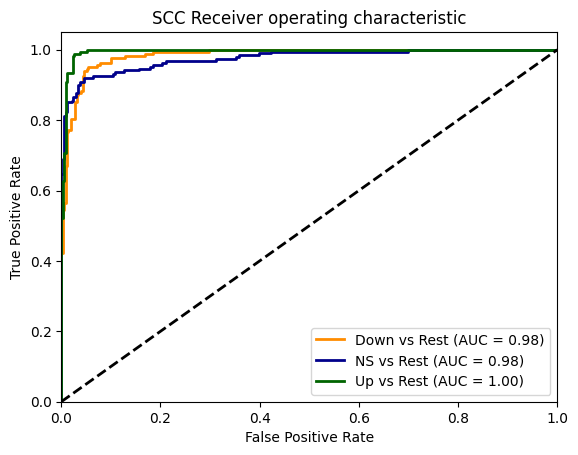

In [ ]:
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='Down vs Rest (AUC = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='darkblue',
         lw=lw, label='NS vs Rest (AUC = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='darkgreen',
         lw=lw, label='Up vs Rest (AUC = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SCC Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
target_names = ['Down', 'NS', 'UP']
y_pred = classifier.predict(X_test)
y_pred1=np.argmax(y_pred, axis=1)
y_test1=np.argmax(y_test, axis=1)
print(classification_report(y_test1, y_pred1, target_names=target_names))

              precision    recall  f1-score   support

        Down       0.94      0.97      0.95       307
          NS       0.98      0.91      0.94       308
          UP       0.96      0.99      0.98       283

    accuracy                           0.96       898
   macro avg       0.96      0.96      0.96       898
weighted avg       0.96      0.96      0.96       898



In [ ]:
cf_matrix=confusion_matrix(y_test1,y_pred1)

Text(0.5, 1.0, 'SCC confusion matrix')

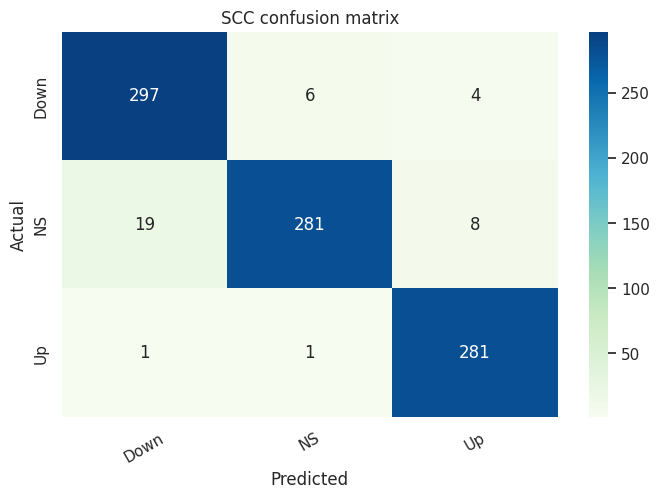

In [ ]:
df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_test1), index = np.unique(y_test1))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
class_labels=['Down','NS','Up']
tick_marks=np.arange(len(class_labels))+0.5
plt.figure(figsize = (8,5))
sns.set(font_scale=1)#for label size
axes=sns.heatmap(df_cm, cmap=plt.cm.GnBu, annot=True,annot_kws={"size": 12},fmt='.0f')# font size
axes.set_xticks(tick_marks)
axes.set_xticklabels(class_labels,rotation=30)

axes.set_yticks(tick_marks)
axes.set_yticklabels(class_labels,rotation=90)
axes.set_title("SCC confusion matrix")

In [ ]:
classifiers_list=[clf1,clf2,clf5]
names=['KNN','RF','GB']

In [ ]:
for clf in range(len(classifiers_list)):
  print(names[clf])

KNN
RF
GB


https://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/

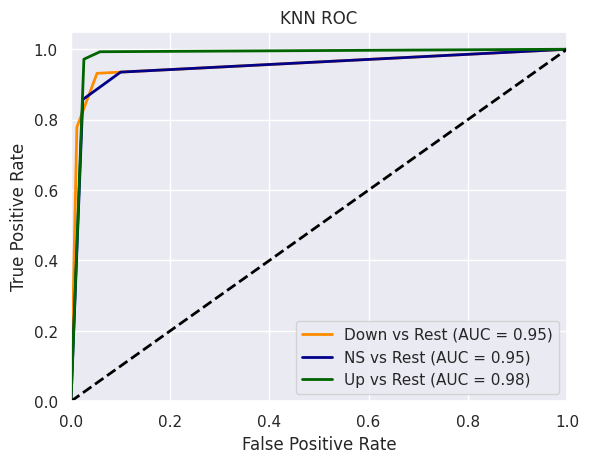

              precision    recall  f1-score   support

        Down       0.87      0.93      0.90       307
          NS       0.95      0.86      0.90       308
          UP       0.95      0.97      0.96       283

    accuracy                           0.92       898
   macro avg       0.92      0.92      0.92       898
weighted avg       0.92      0.92      0.92       898



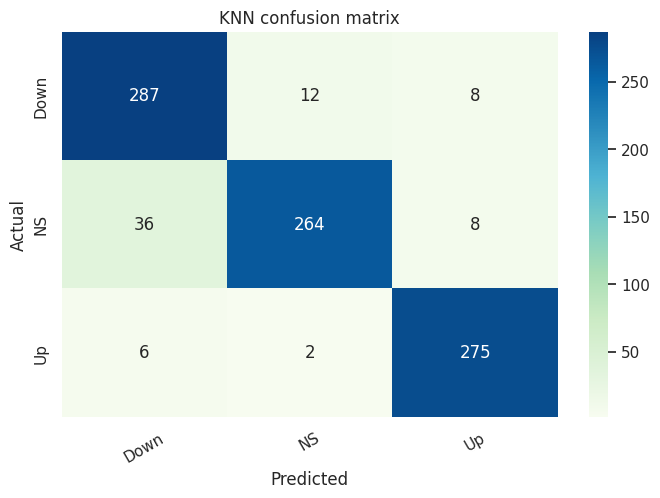

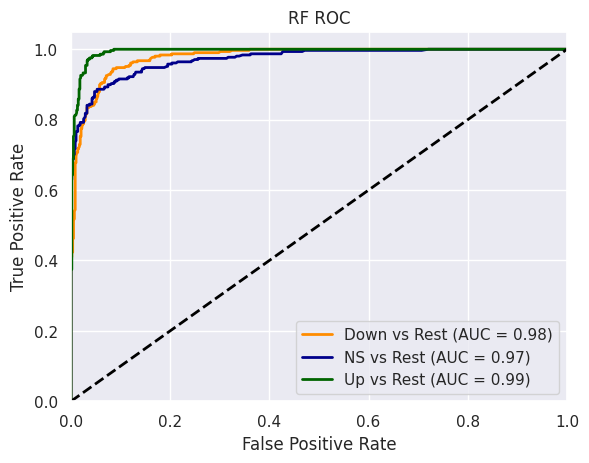

              precision    recall  f1-score   support

        Down       0.83      0.94      0.88       307
          NS       0.95      0.79      0.86       308
          UP       0.92      0.97      0.94       283

    accuracy                           0.90       898
   macro avg       0.90      0.90      0.90       898
weighted avg       0.90      0.90      0.90       898



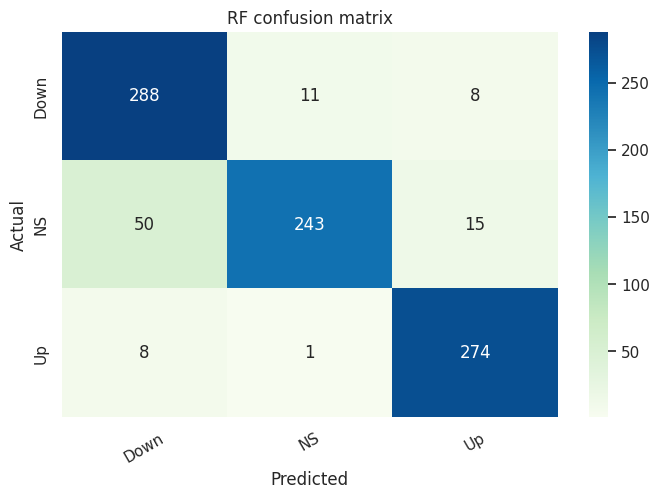

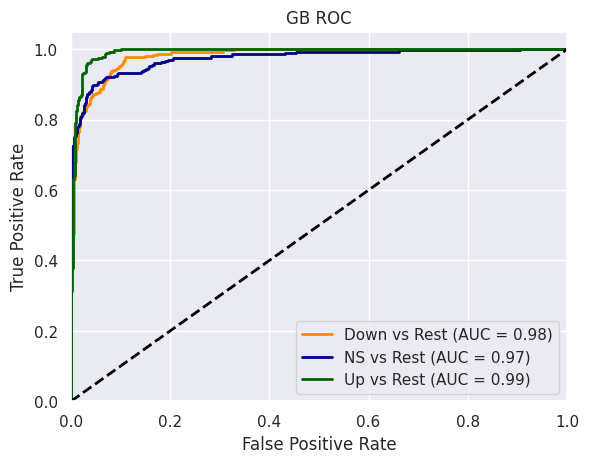

              precision    recall  f1-score   support

        Down       0.86      0.95      0.90       307
          NS       0.97      0.82      0.89       308
          UP       0.93      0.97      0.95       283

    accuracy                           0.91       898
   macro avg       0.92      0.91      0.91       898
weighted avg       0.92      0.91      0.91       898



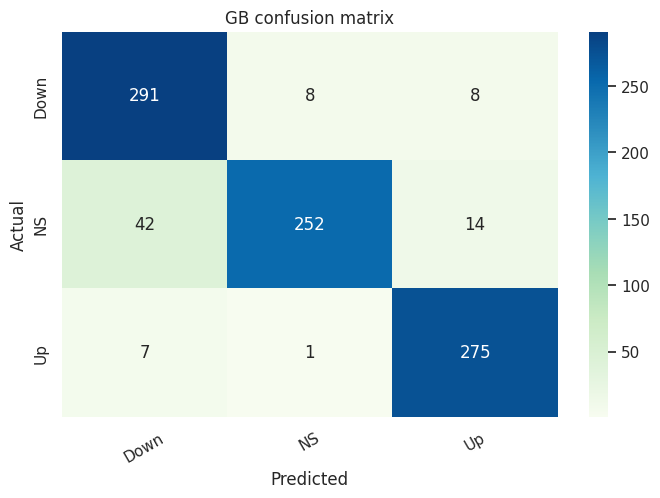

In [ ]:

for c in range(len(classifiers_list)):
  classifier = OneVsRestClassifier(classifiers_list[c])
  y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  plt.figure()
  lw = 2
  plt.plot(fpr[0], tpr[0], color='darkorange',
          lw=lw, label='Down vs Rest (AUC = %0.2f)' % roc_auc[0])
  plt.plot(fpr[1], tpr[1], color='darkblue',
          lw=lw, label='NS vs Rest (AUC = %0.2f)' % roc_auc[1])
  plt.plot(fpr[2], tpr[2], color='darkgreen',
          lw=lw, label='Up vs Rest (AUC = %0.2f)' % roc_auc[2])
  plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  title=names[c]+' ROC'
  plt.title(title)
  plt.legend(loc="lower right")
  plt.show()

  target_names = ['Down', 'NS', 'UP']
  y_pred = classifier.predict(X_test)
  y_pred1=np.argmax(y_pred, axis=1)
  y_test1=np.argmax(y_test, axis=1)
  print(classification_report(y_test1, y_pred1, target_names=target_names))

  #confusion mat
  cf_matrix=confusion_matrix(y_test1,y_pred1)
  df_cm = pd.DataFrame(cf_matrix, columns=np.unique(y_test1), index = np.unique(y_test1))
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  class_labels=['Down','NS','Up']
  tick_marks=np.arange(len(class_labels))+0.5
  plt.figure(figsize = (8,5))
  sns.set(font_scale=1)#for label size
  axes=sns.heatmap(df_cm, cmap=plt.cm.GnBu, annot=True,annot_kws={"size": 12},fmt='.0f')# font size
  axes.set_xticks(tick_marks)
  axes.set_xticklabels(class_labels,rotation=30)

  axes.set_yticks(tick_marks)
  axes.set_yticklabels(class_labels,rotation=90)
  axes.set_title(names[c]+" confusion matrix")
